In [206]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [207]:
def resize_image(img_path, size):
    try:
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"Image at {img_path} could not be read.")
        resized_img = cv.resize(img, size)
        return resized_img
    except Exception as e:
        print(f"Error resizing image {img_path}: {e}")
        return None

Loading dataset...
Dataset loaded with 396 images across 4 classes.


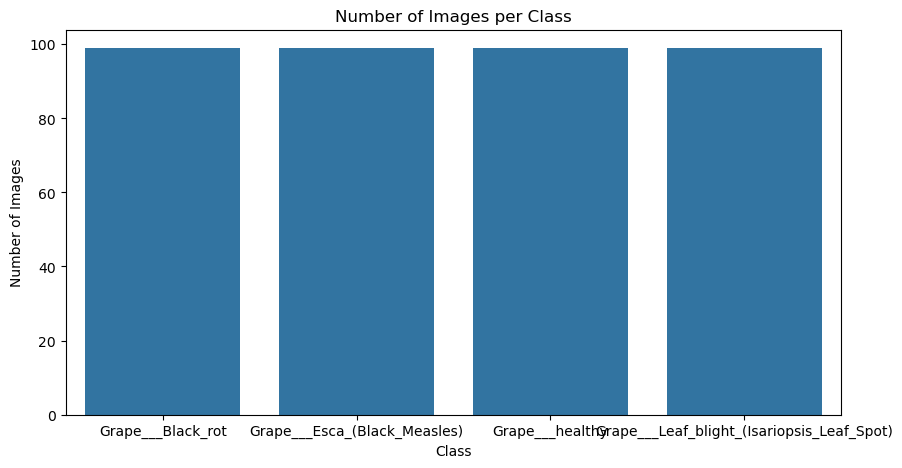

In [208]:
def load_dataset(dir):
    size = (250,250)
    images = []
    labels = []
    class_names = os.listdir(dir)
    class_counter = {class_name: 0 for class_name in class_names}

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if class_counter[class_name] >= 100:
                    break
                img_path = os.path.join(class_dir, file_name)
                img = resize_image(img_path, size)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
                    class_counter[class_name]+=1
    return np.array(images), np.array(labels), class_names, class_counter


print("Loading dataset...")
images, labels, class_names, class_counter = load_dataset('dataset')
print(f"Dataset loaded with {len(images)} images across {len(class_names)} classes.")
# Diagram Dataset
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counter.keys()), y=list(class_counter.values()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.savefig('dataset_distribution.png')
plt.show()

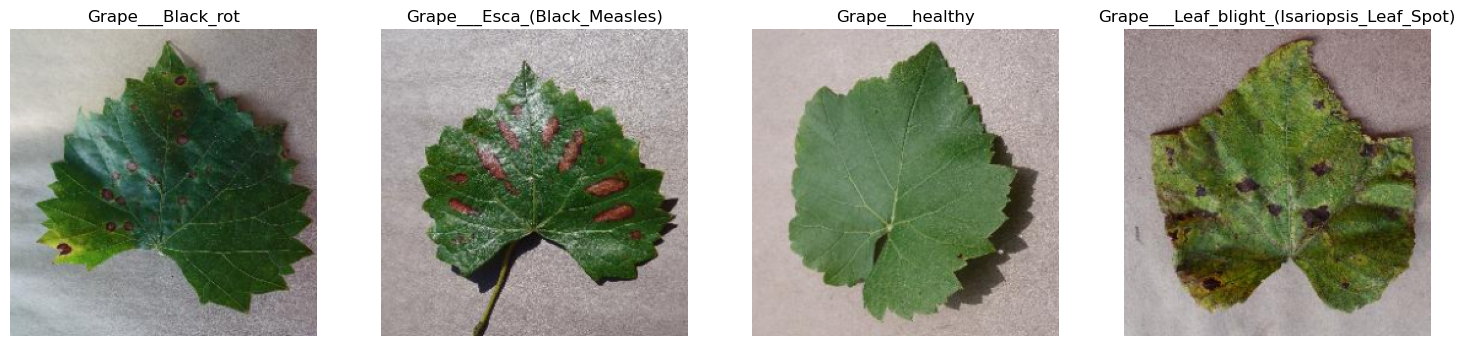

In [209]:
# Menampilkan gambar sample dari setiap kelas
def show_sample_images(images, labels, class_names):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_images = images[labels == class_name]
        if len(class_images) > 0:
            plt.subplot(3, 4, i + 1)
            plt.imshow(cv.cvtColor(class_images[10], cv.COLOR_BGR2RGB))
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
show_sample_images(images, labels, class_names)

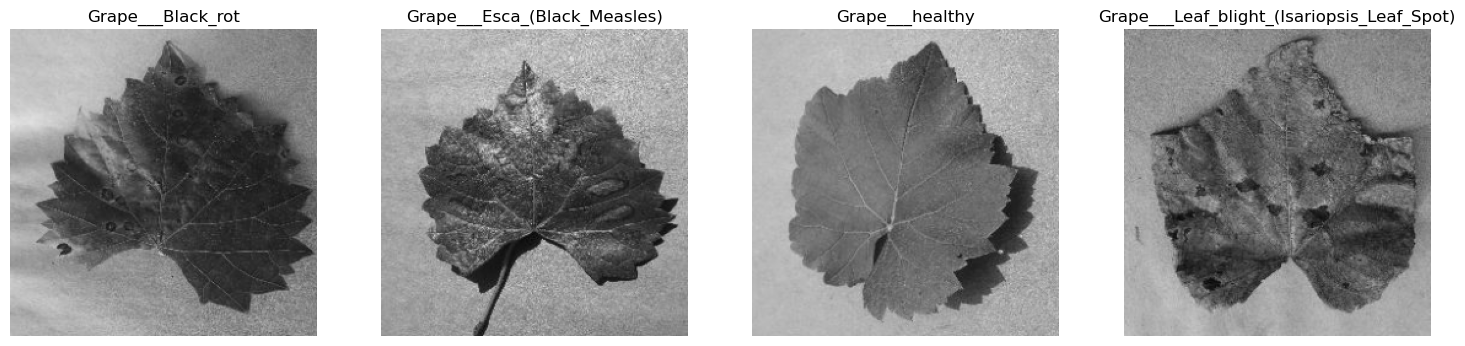

In [210]:
img_grey = []
for img in images:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_grey.append(gray)
img_grey = np.array(img_grey)

show_sample_images(img_grey, labels, class_names)

### **PreProcessing 3** **(Prewitt, MEDIAN)**

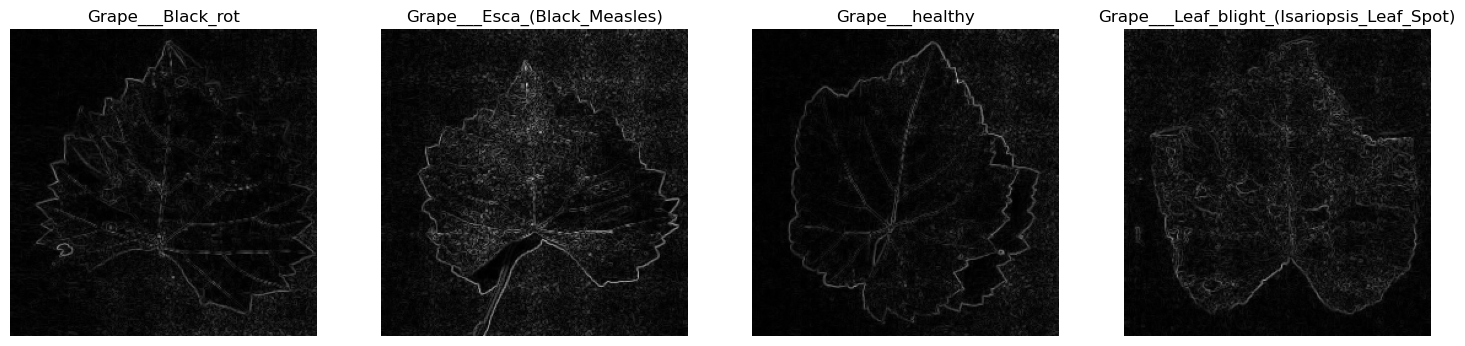

In [211]:
# Kernel Prewitt
from regex import R


Px = np.array([[-1,0,1],
               [-1,0,1],
               [-1,0,1]])

Py = np.array([[1,1,1],
               [0,0,0],
               [-1,-1,-1]])

Sx = np.array([[-1,0,1],
               [-2,0,2],
               [-1,0,1]])

Sy = np.array([[1,2,1],
               [0,0,0],
               [-1,-2,-1]])
Rpos = np.array([[1,0],
               [0,-1]])

Rmin = np.array([[0,1],
               [-1,0]])

def padding_baris(image):
    height, width = image.shape
    img_pad = np.zeros((height, width + 1))
    img_pad[:, :width] = image
    return img_pad

def padding_kolom(image):
    height, width = image.shape
    img_pad = np.zeros((height + 1, width))
    img_pad[:height, :] = image
    return img_pad

# Fungsi konvolusi edge
def convo_edge(image, kernel, jenis):
    img_height, img_width = image.shape
    k_height, k_width = kernel.shape
    p_height, p_width = k_height // 2, k_width // 2

    if jenis.lower() != "roberts":
        padded_img = np.pad(image, ((p_height, p_height), (p_width, p_width)), mode='reflect')
    else:
        padded_img = padding_kolom(padding_baris(image))

    result = np.zeros((img_height, img_width))

    for i in range(img_height):
        for j in range(img_width):
            region = padded_img[i:i + k_height, j:j + k_width]
            result[i, j] = np.sum(region * kernel)

    return result

# Fungsi deteksi tepi
def deteksi_tepi(image, kernelX, kernelY, jenis):
    hasilX = convo_edge(image, kernelX, jenis)
    hasilY = convo_edge(image, kernelY, jenis)
    magnitude = np.sqrt(hasilX**2 + hasilY**2)
    return np.clip(magnitude, 0, 255).astype(np.uint8)

# Proses ke semua gambar
img_rob = []
for img in img_grey:
    sobel = deteksi_tepi(img, Rpos, Rmin, jenis="sobel")
    img_rob.append(sobel)
img_rob = np.array(img_rob)

# Tampilkan sample gambar
show_sample_images(img_rob, labels, class_names)


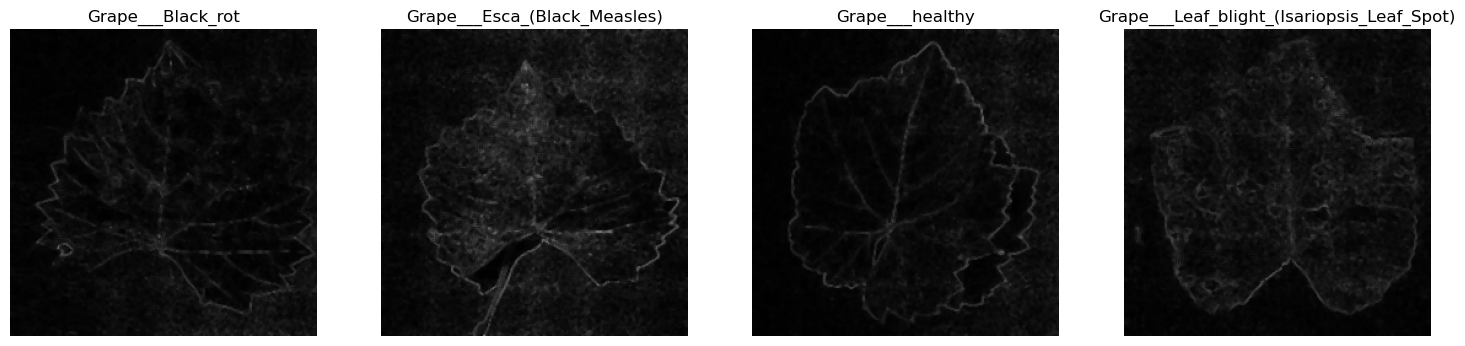

In [212]:
kernel_3x3 = np.full((3, 3), 1/9)

def hitung_median(image):
    return np.median(image)

def convo_statistik(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    padded_img = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros_like(image)

    for i in range(img_height):
        for j in range(img_width):
            tmp = padded_img[i:i+kernel_height, j:j+kernel_width]
            result[i, j] = hitung_median(tmp)
    return result

# Menerapkan konvolusi median
img_median = []
for img in img_rob:
    median_img = convo_statistik(img, kernel_3x3)
    img_median.append(median_img)
img_median = np.array(img_median)
show_sample_images(img_median, labels, class_names)

### Feature Extraction

In [213]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")

    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [214]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [215]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [216]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [217]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [218]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [219]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [220]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [221]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(img_median)):
    D0 = glcm(img_median[i], 0)
    D45 = glcm(img_median[i], 45)
    D90 = glcm(img_median[i], 90)
    D135 = glcm(img_median[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [222]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [223]:
for i in range(len(img_median)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [224]:
for i in range(len(img_median)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [225]:
for i in range(len(img_median)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [226]:
for i in range(len(img_median)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [227]:
for i in range(len(img_median)):
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [228]:
for i in range(len(img_median)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [229]:
for i in range(len(img_median)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV

In [230]:
dataTable = {'Filename': [f'Image_{i+1}' for i in range(len(img_median))],
        'Class': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_pros3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_pros3.csv')
hasilEkstrak = hasilEkstrak.drop(columns=['Filename'])
x = hasilEkstrak.drop(columns=['Class'])
y = hasilEkstrak['Class']


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

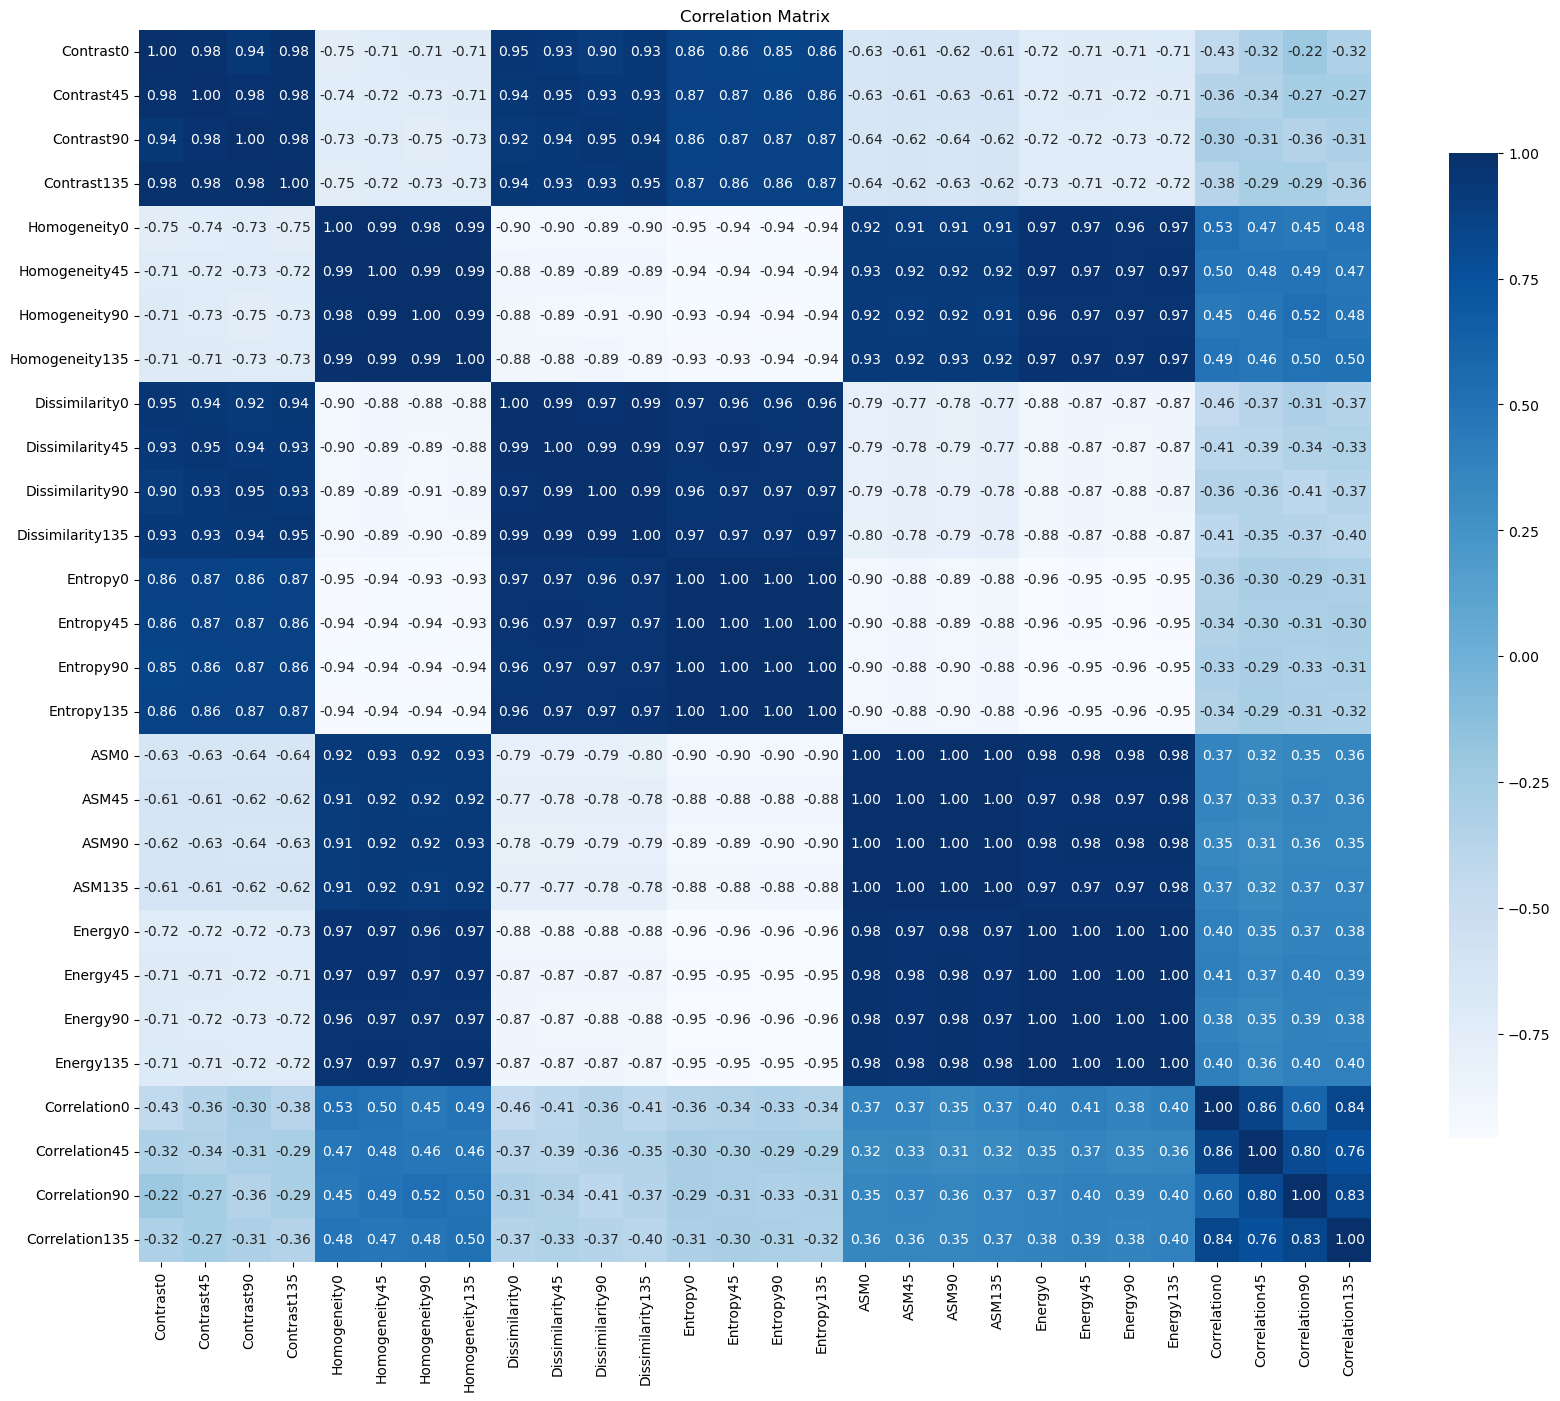

In [231]:
# Menghitung Korelasi
correlation_matrix = x.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Blues', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix3.png')
plt.show()

## Splitting Data

In [232]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(f"Training set size: {len(x_train)}, Test set size: {len(x_test)}")
print(f"Training set size: {len(y_train)}, Test set size: {len(y_test)}")


Training set size: 277, Test set size: 119
Training set size: 277, Test set size: 119


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [233]:
# normalisasi mean std
def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    return normalized_data
x_train = normalize_data(x_train)
x_test = normalize_data(x_test)

## Modeling

### Define Model

In [234]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [235]:
# Train Random Forest Classifier
rf.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(x_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.88      0.90      0.89        62
              Grape___Esca_(Black_Measles)       0.93      0.90      0.91        71
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.93      0.90      0.91        71
                           Grape___healthy       0.92      0.95      0.93        73

                                  accuracy                           0.91       277
                                 macro avg       0.91      0.91      0.91       277
                              weighted avg       0.91      0.91      0.91       277

[[56  1  2  3]
 [ 3 64  3  1]
 [ 1  4 64  2]
 [ 4  0  0 69]]
Accuracy: 0.9133574007220217

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.64      0.62      0.63        37
              Gr

### Train SVM Classifier

In [236]:
# Train SVM Classifier
svm.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(x_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.59      0.52      0.55        62
              Grape___Esca_(Black_Measles)       0.61      0.77      0.68        71
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.65      0.49      0.56        71
                           Grape___healthy       0.66      0.71      0.68        73

                                  accuracy                           0.63       277
                                 macro avg       0.63      0.62      0.62       277
                              weighted avg       0.63      0.63      0.62       277

[[32 11  3 16]
 [ 4 55  6  6]
 [ 7 24 35  5]
 [11  0 10 52]]
Accuracy: 0.628158844765343

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.73      0.51      0.60        37
              Gr

### Train KNN Classifier

In [237]:
# Train KNN Classifier
knn.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(x_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.63      0.65      0.64        62
              Grape___Esca_(Black_Measles)       0.73      0.69      0.71        71
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.72      0.65      0.68        71
                           Grape___healthy       0.73      0.84      0.78        73

                                  accuracy                           0.71       277
                                 macro avg       0.70      0.70      0.70       277
                              weighted avg       0.71      0.71      0.71       277

[[40  4  4 14]
 [ 8 49  9  5]
 [ 9 13 46  3]
 [ 6  1  5 61]]
Accuracy: 0.7075812274368231

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.77      0.62      0.69        37
              G

## Evaluation With Confusion Matrix

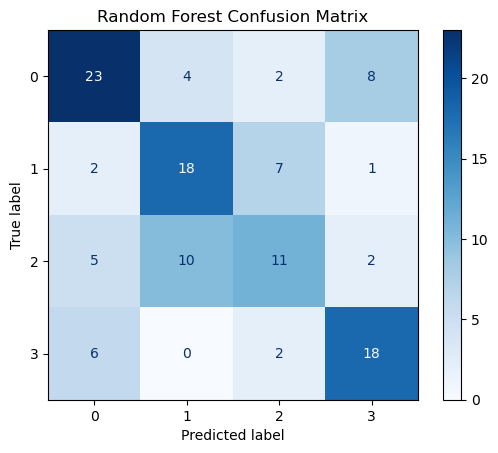

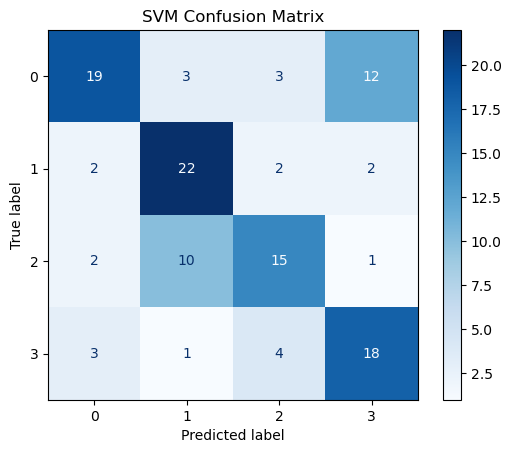

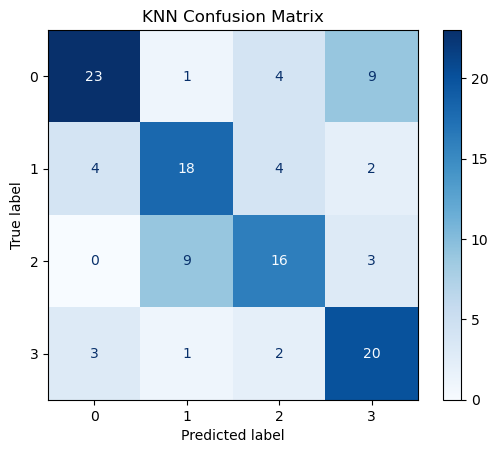

In [238]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(x_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(x_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(x_test), "KNN Confusion Matrix")